# Assignment #3 - Neural Networks
### <font color="red"> DUE: November 13 (Friday) 11:00 pm </font>  

<font color="blue"> Yike Li </font>

# I. Overview

<font color="blue"> Describe the objective of this assignment. You can briefly state how you accompilsh it.

The objective of the assignment is to use the given neural network super class and apply it on both the regression and classification problem. 
    
First, I start with the regression problem in Assignment 1 using the given class in "nn" file without modification. For the classification problem, I use the classification dataset in Assignment 2 and developed a subclass to redefine/override several methods in the superclass. For both problems, a 5-fold cross validation is used to test the model performance, the main challenge here is to try out different neural network structures within manageable training time. We found out that increasing the number of layer will dramatically increase the training time on a personal laptop, so we proceed with tuning the number of neurons in a shallow network, which has a fixed one hidden layer.

For the bonus credit problem, I learn about different activation functions and create a new subclass to modify the forward/backward propagation method to make it working.

# II. Data

<font color="blue"> Introduce your data and visualize them. Describe your observations about the data.
You can reuse the data that you examined in Assignment #1 (of course for regression). 

The following cell imports all packages needed. 

In [1]:
# import
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nn import NeuralNet
from scipy.special import expit  # logistic sigmoid function
from pandas.plotting import register_matplotlib_converters
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

register_matplotlib_converters()

## Regression Data

The following cell loads the original regression dataset. This dataset comes from the load forecasting track of GEFCom2014-E (Global Energy Forecasting Competition). The entire data set consists of hourly load data of the 1st hour of 1/1/2006 to the last hour of 12/31/2014, with hourly temperature history. Since the dataset contains in total of 9 years load data and I am only using the **last 6 years** (2009-2014) data for EDA and later experiments.

Further details about GEFCom2014 can be found in this [link](http://blog.drhongtao.com/2017/03/gefcom2014-load-forecasting-data.html). 

The dataset will be loaded in the following cell, and some feature engineering has been conducted, such as extracting weekday, month from the date column, taking power of temperature column, and adding a linear trend.

In [2]:
# Add trend column
def add_trend(df):
    """Add Linear trend """
    df = df.reset_index(drop=True)  # reset index before concatenate
    trend = pd.Series(np.arange(1, len(df) + 1, 1, dtype=int), name='trend')
    return pd.concat([df, trend], axis=1)


# Load the regression dataset, GEFCOM2012 load forecasting track, loads are in kW
user = 'Administrator'
load = pd.read_excel(f'C:/Users/{user}/Dropbox/Misc/ITCS 8156/HW/GEFCom2014-E.xlsx')
load['year'] = load.date.dt.year
load = load[load.year.isin(np.unique(load.year)[-6:])]
load.load = load.load/1000 # convert to GW
load = add_trend(load)
load['month'] = load.date.dt.month
load['weekday'] = load.date.dt.dayofweek

Here is how the dataset looks like, as well as the some of the basic statistics. This dataset is pre-cleaned and thus is ready for data visualization.

In [3]:
load.head(10)

,date,hour,load,T,year,trend,month,weekday
0,2009-01-01,1,3.223,4.333333,2009,1,1,3
1,2009-01-01,2,3.082,4.000000,2009,2,1,3
2,2009-01-01,3,2.997,3.333333,2009,3,1,3
3,2009-01-01,4,2.968,3.000000,2009,4,1,3
4,2009-01-01,5,2.990,3.000000,2009,5,1,3
5,2009-01-01,6,3.069,2.666667,2009,6,1,3
6,2009-01-01,7,3.199,2.333333,2009,7,1,3
7,2009-01-01,8,3.316,2.333333,2009,8,1,3
8,2009-01-01,9,3.504,2.333333,2009,9,1,3
9,2009-01-01,10,3.694,3.666667,2009,10,1,3


In [4]:
load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     52584 non-null  datetime64[ns]
 1   hour     52584 non-null  int64         
 2   load     52584 non-null  float64       
 3   T        52584 non-null  float64       
 4   year     52584 non-null  int64         
 5   trend    52584 non-null  int32         
 6   month    52584 non-null  int64         
 7   weekday  52584 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4)
memory usage: 3.0 MB


The hourly load plot and hourly temperature plot are shown below. We see very strong yearly seasonality for both the Load (up) and the Temperature (down). 

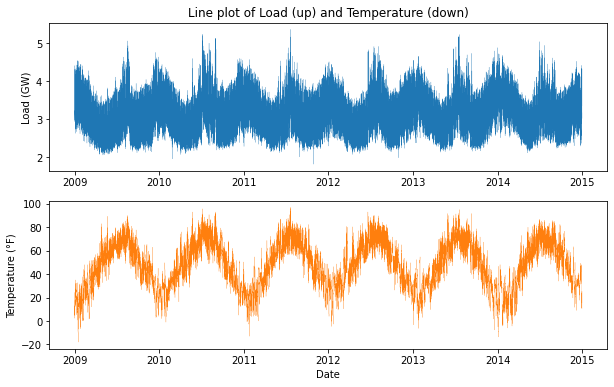

In [5]:
# 2012 Hourly Load and Temperature curve
plt.figure(figsize=(10, 6))
plt.subplot(211)  # Hourly load plot
plt.title('Line plot of Load (up) and Temperature (down)', fontsize=12)
plt.plot(load.date, load.load, lw=.2)
plt.ylabel('Load (GW)')
plt.subplot(212)  # Hourly temperature plot
plt.plot(load.date, load['T'], lw=.2, c='tab:orange')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.show()

Temperature is known to have a strong correlation with electricity usage patterns. The plot below shows the scatterplot of load – temperature relationship. The graph shows a strong correlation (the typical “hockey stick” shape) between the load and temperature. On the left arm, the load goes up for heating needs during the winter when the temperature drops below a certain point. On the right arm, the load goes up for cooling needs during the summer when the temperature increases. This scatterplot shows that there is a cutoff point at around 55 Fahrenheit.

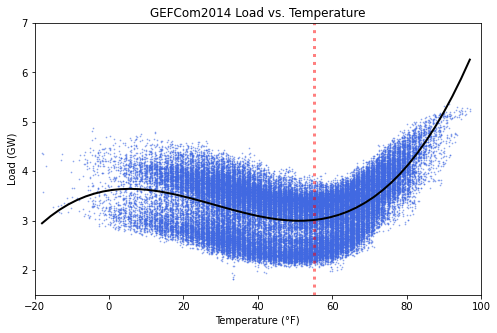

In [6]:
# 2012 Load vs. Temperature w/ fitted curve
from numpy.polynomial.polynomial import polyfit, polyval

plt.figure(figsize=(8, 5))
plt.scatter(load['T'], load.load, s=0.5,alpha=0.5, marker="o", c='royalblue')
plt.axvline(x=55, color='red', linestyle=':', alpha=0.5,linewidth=3)  # vertical dotted line
plt.title('GEFCom2014 Load vs. Temperature')
coefs = polyfit(load['T'], load.load, 3)  # fit 3rd order polynomial
x_new = np.linspace(min(load['T']), np.max(load['T']))
ffit = polyval(x_new, coefs)
plt.plot(x_new, ffit, '-', c='black', linewidth=2)
plt.xlim(-20, 100)
plt.ylim(1.5, 7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Load (GW)')
plt.show()

To model the annual seasonality, the categorical variables – month, have been included to categorize load patterns throughout the year. The figure below gives the scatterplots of load – temperature relationship at each month of a year from the aggregated zone and the average temperature from the 11 stations in this case study. The correlation between the load and temperature during the winter months (Month=12, 1, 2, 3) and summer months (Month=6, 7, 8, 9) is stronger than the remaining months, largely due to during these 6 months, load tends to increase when the weather (temperature here) gets extreme. In the remaining 4 months (Month=4, 5, 10, 11), the relationship between the two is weak.

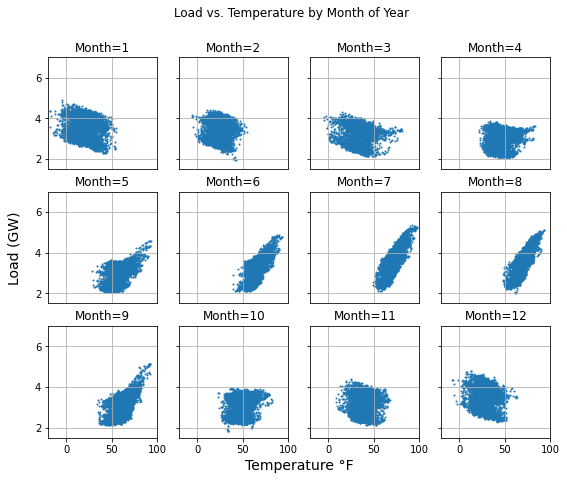

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex='col',
                       sharey='row', figsize=(9, 7))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False,
                bottom=False, left=False, right=False)
# plt.rcParams['ytick.labelsize'] = 10
plt.xlabel('Temperature °F', fontsize=14)
plt.ylabel('Load (GW)', fontsize=14)
fig.suptitle('Load vs. Temperature by Month of Year')
for i in range(4):  # col
    for j in range(3):  # row
        ax[j, i].scatter(load.loc[load['month'] == i + j * 4 + 1]['T'],
                         load.loc[load['month'] == i + j * 4 + 1].load, s=1)
        ax[j, i].set_title('Month=' + str(i + j * 4 + 1), fontsize=12)
        # set xlim and ylim for each subplot
        ax[j, i].set(xlim=(-20, 100), ylim=(1.5, 7))
        ax[j, i].grid(True)  # add gridlines
        if j != 2:
            ax[j, i].xaxis.set_ticks_position('none')  # remove xsticks
plt.show()

Moreover, the hour of day is known to have impacts on electricity usage. Human being’s activities vary at different time of a day, thus result in different load patterns – for a person who has a regular day job, on a workday, he/she will wake up in the morning and go out for work, get home by the evening, and go to bed during the night. From the plot below, we can tell that the load-temperature relationship is slightly different at each hour of day. 

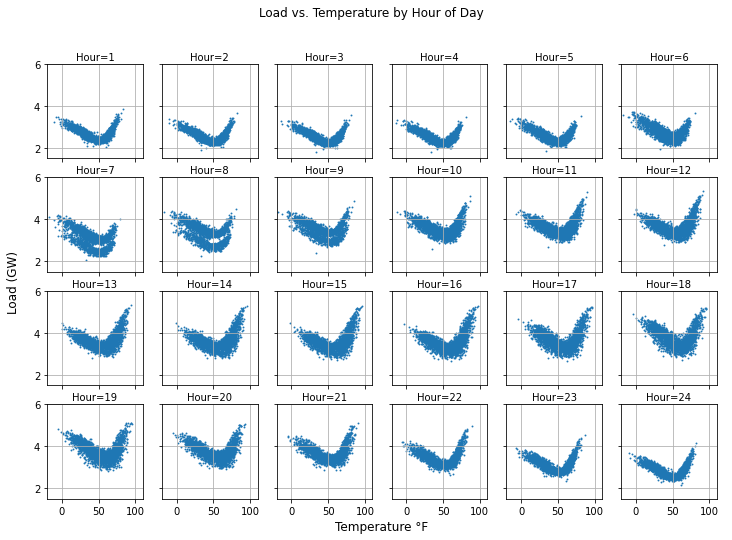

In [8]:
# 2012 Load vs. Temperature by Hour
fig, ax = plt.subplots(nrows=4, ncols=6, sharex='col', sharey='row', figsize=(12, 8))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Temperature °F', fontsize=12)
plt.ylabel('Load (GW)', fontsize=12)
fig.suptitle('Load vs. Temperature by Hour of Day')
for i in range(6):  # col
    for j in range(4):  # row
        ax[j, i].scatter(load.loc[load['hour'] == i + j * 6 + 1]['T'],
                         load.loc[load['hour'] == i + j * 6 + 1].load, s=.8)
        ax[j, i].set_title('Hour=' + str(i + j * 6 + 1), fontsize=10)
        ax[j, i].title.set_position([.5, .98])  # adjust distance between title and plot
        ax[j, i].set(xlim=(-20, 110), ylim=(1.5, 6))  # set xlim and ylim for each subplot
        ax[j, i].xaxis.set_ticks(np.arange(0, 110, 50))
        ax[j, i].grid(True)  # add gridlines

# plt.savefig('filename.png', bbox_inches='tight') # save plot, 'tight' fits for subplots
plt.show()

At last, people can have disparate schedules on a weekday compared to a weekend day, therefore leads to different electricity usage patterns. Between the two different weekdays or weekend days, the load pattern could differ as well. For instance, people might stay up late on Fridays compared to the other weekdays; the wake-up time on Sunday may be different for people who need to get up earlier for church ceremonies. Below gives the line plot of a week in early 2009. The different colors defines the load curve at different day of week, which suggests that each day may have a unique load pattern. 

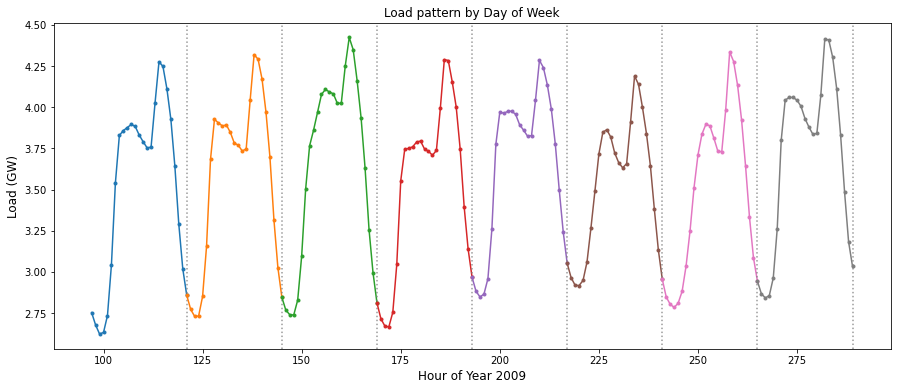

In [9]:
plt.figure(figsize=(15,6))
for i in range(96, 7*24+96+1, 24):
    plt.plot(load.trend[i:i+24+1], load.load[i:i+24+1], marker='o', markersize=3)
    plt.axvline(x=i+24+1, color='gray', linestyle=':', alpha=0.8)
plt.xlabel('Hour of Year 2009', size=12)
plt.ylabel('Load (GW)', size=12)
plt.title('Load pattern by Day of Week')
plt.show()

**To summarize, the features we will be using for the modeling phase are:**
- (Categorical) Month of year
- (Categorical) Hour of day
- (Categorical) Day of week
- (Numerical) Temperature and a linear trend

## Classification Data

The following cell loads the original classification dataset. The context of this dataset is that a Taiwan-based credit card issuer wants to better predict the likelihood/probability of default for its customers at the following month, as well as identify the key drivers that determine this likelihood. This can inform the issuer’s decisions on who to give a credit card to and what credit limit to provide. It would also help the issuer have a better understanding of their current and potential customers, which would inform their future strategy, including their planning of offering targeted credit products to their customers.

This dataset contains information on 30000 customers and each with 24 features, including demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005, as well as the outcome of whether the customer default or not. The dataset can be downloaded from this [link](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). 

Below gives the descriptions of the 24 features and the last row - "default.payment.next.month", is the binary target variable, indicating whether the client defaulted for the following month (Oct 2005). 

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_1: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

- **default.payment.next.month: Did the customer default (1=yes, 0=no)**

The following cell imports all used packages and the dataset. 

In [10]:
# import
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()

# Load the UCI_Credit_Card dataset
user = 'Administrator'
df = pd.read_csv(f'C:/Users/{user}/Dropbox/Misc/ITCS 8156/HW/UCI_Credit_Card.csv')
df.rename(columns={'PAY_0': 'PAY_1', 'default.payment.next.month': 'default'}, inplace=True)

Take a look at the first five rows.

In [11]:
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Observing the statistics of each variable, we can see that the average age of the customers is 35.5. The mean available credit is 167k while the std is quite large. The maximum credit limit is 1M. From our target variable, "default.payment.next.month", the mean of 0.221 suggests that there are about 22.1% customers will default in the next month. 

In [12]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


The following plot shows a histogram for each variable in the dataset.

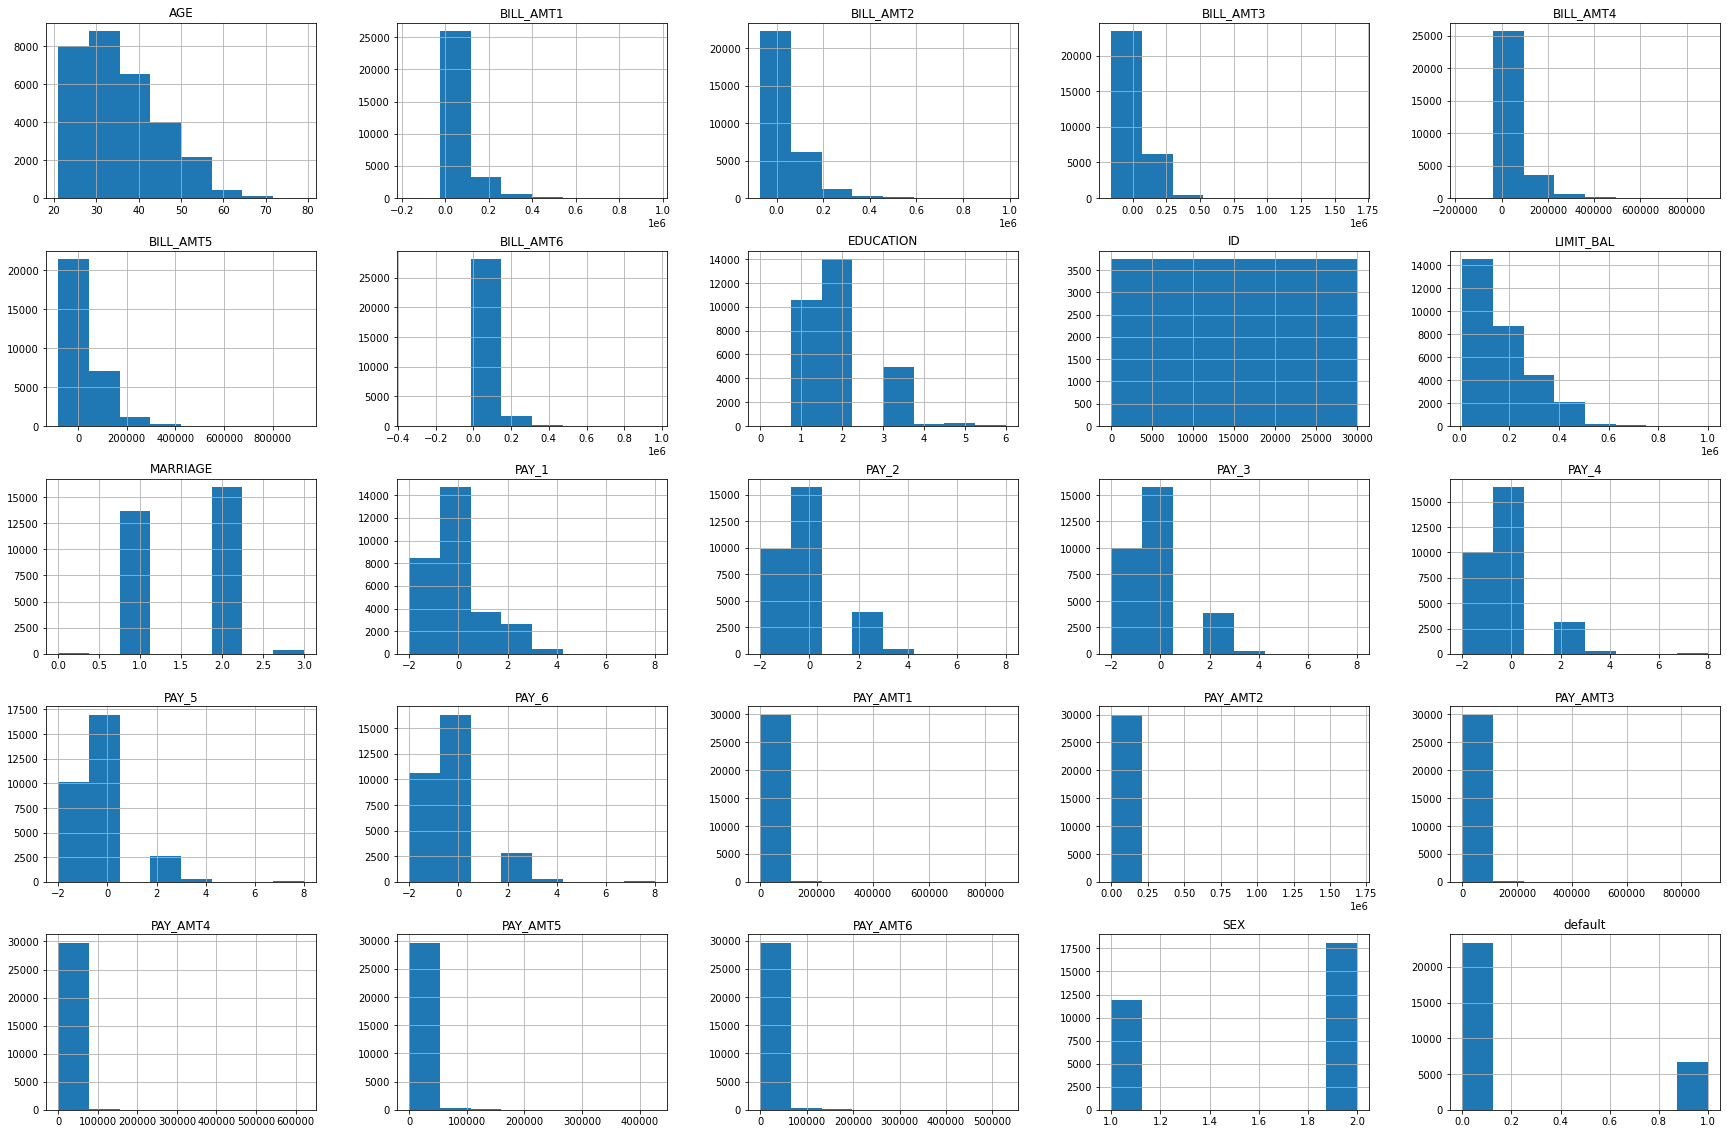

In [13]:
df.hist(figsize=(30,20), bins=8)
plt.show()

Next, we want to get an idea of the features that can be considered to separate the target variable, such that in the later stage, we can use the features that have most discriminatory power in our classification model.

First, I use the following plots to show the repayment status (PAY_1 - PAY_6, each has 12 states of status), amount of previous payment (PAY_AMT1 - PAY_AMT6), and amount of billing statement (BILL_AMT1 - BILL_AMT6) at each month for non-defaulted (class=0, left plots) and defaulted (class=1, right plots) customers.

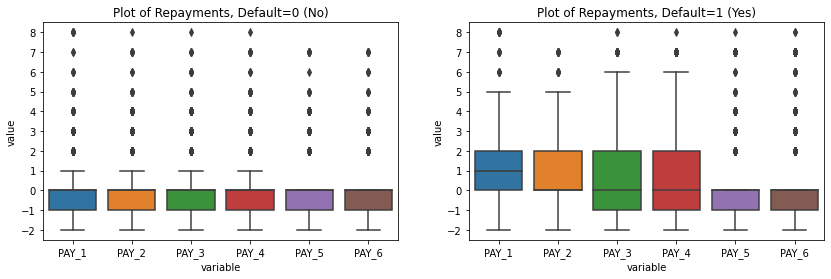

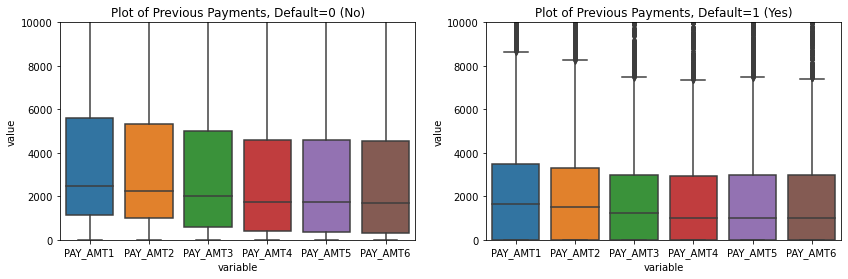

Non-defaulted customers:
             PAY_AMT1      PAY_AMT2       PAY_AMT3       PAY_AMT4  \
count   23364.000000  2.336400e+04   23364.000000   23364.000000   
mean     6307.337357  6.640465e+03    5753.496833    5300.529319   
std     18014.508990  2.530226e+04   18684.255937   16689.778060   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1163.750000  1.005000e+03     600.000000     390.000000   
50%      2459.500000  2.247500e+03    2000.000000    1734.000000   
75%      5606.250000  5.311250e+03    5000.000000    4602.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

            PAY_AMT5       PAY_AMT6  
count   23364.000000   23364.000000  
mean     5248.220296    5719.371769  
std     16071.667860   18792.950473  
min         0.000000       0.000000  
25%       369.000000     300.000000  
50%      1765.000000    1706.000000  
75%      4600.000000    4545.000000  
max    426529.000000  528666.000000   

Defaulted custome

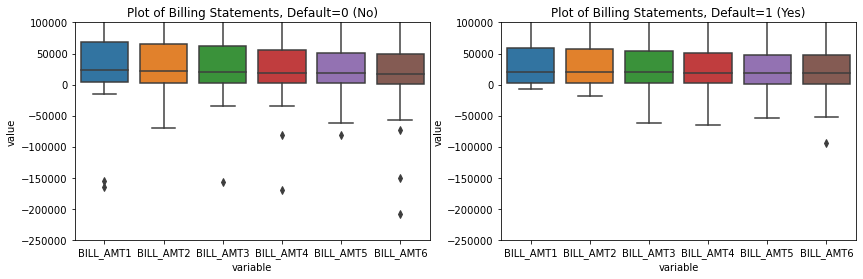

In [14]:
def filter_df(data, col_from='PAY_1', col_to='PAY_6'):
    """Select subset columns from dataframe"""
    data_plot = data.iloc[:, data.columns.get_loc(col_from):data.columns.get_loc(col_to) + 1]
    return data_plot


def multivariate_boxplot(title, col_from, col_to, set_yticks=False, yticks=np.arange(-2, 8 + 1, 1),
                         set_ylim=False, ylim=(0, 1.25e6)):
    """Produce boxplots that include multiple columns in dataframe. """
    plt.figure(figsize=(14, 4))
    ax1 = plt.subplot(121)
    df_plot = filter_df(df_0, col_from=col_from, col_to=col_to)
    sns.boxplot(x='variable', y='value', data=pd.melt(df_plot))  # PAY_1 - PAY_6
    if set_yticks:
        plt.yticks(yticks)
    if set_ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.title(f'Plot of {title}, Default=0 (No)')
    ax2 = plt.subplot(122, sharey=ax1)  # share the y axis of ax1
    df_plot = filter_df(df_1, col_from=col_from, col_to=col_to)
    sns.boxplot(x='variable', y='value', data=pd.melt(df_plot))  # PAY_1 - PAY_6
    plt.title(f'Plot of {title}, Default=1 (Yes)')
    plt.show()


def univariate_plot(title, col):
    """Produce barcharts for a single variable, grouped by default status. """
    group_df = df.groupby(['default', col])[col].count().unstack(0)
    group_df.iloc[:, 0] = 100 * group_df.iloc[:, 0] / group_df.iloc[:, 0].sum()  # convert to %
    group_df.iloc[:, 1] = 100 * group_df.iloc[:, 1] / group_df.iloc[:, 1].sum()  # convert to %
    ax = group_df.plot.bar(title=f'"Default" status by {title}', figsize=(12, 4))
    ax.set_ylabel('Percentage')
    plt.show()


df_0 = df[df['default'] == 0]
df_1 = df[df['default'] == 1]

# For repayments
multivariate_boxplot(title='Repayments', col_from='PAY_1', col_to='PAY_6', set_yticks=True)
# For previous payments
multivariate_boxplot(title='Previous Payments', col_from='PAY_AMT1', col_to='PAY_AMT6', set_ylim=True, ylim=(0, 1e4))
print('Non-defaulted customers:\n', df_0.loc[:, 'PAY_AMT1': 'PAY_AMT6'].describe(), '\n')
print('Defaulted customers:\n', df_1.loc[:, 'PAY_AMT1': 'PAY_AMT6'].describe())

# For billing statements
multivariate_boxplot(title='Billing Statements', col_from='BILL_AMT1', col_to='BILL_AMT6', set_ylim=True,
                     ylim=(-0.25e6, 1e5))

From the above plots, we observe that the Repayment status is very different between the defaulted customers and the non-defaulted ones. The defaulted customers were more likely to have payment delays during June-September, 2005 (PAY_1 - PAY_4). From the plots of Previous Payments and the statistics, we observe the non-defaulted customers tend to pay more than the defaulted ones. Regarding the billing statements, these two types of customers were close. 

Then we look at the remaining variables, such as credit limit, sex, education, marriage status and age information. From the statistics and plots below, we can tell that:
- The non-defaulted customers were granted with higher credit limits.
- Male is more likely to gain "default" status than female .
- If a person is married, then he/she is more likely to gain "default" status than being single.
- A person who went to a graduate school has lower chance of getting "default" than a person who only went to an university or high school.

**Up until now, we have identified the following variables to be used in the modeling stage**:
- (Categorical) **Repayment status: PAY_1 - PAY_4**
- (Numerical) **Previous payments: PAY_AMT1 - PAY_AMT6**
- (Numerical) **LIMIT_BAL**, (Categorical) **SEX, EDUCATION, MARRIAGE**

Non-defaulted customers:
             LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE
count    23364.000000  23364.000000  23364.000000  23364.000000  23364.000000
mean    178099.726074      1.614150      1.841337      1.558637     35.417266
std     131628.359660      0.486806      0.806780      0.520794      9.077355
min      10000.000000      1.000000      0.000000      0.000000     21.000000
25%      70000.000000      1.000000      1.000000      1.000000     28.000000
50%     150000.000000      2.000000      2.000000      2.000000     34.000000
75%     250000.000000      2.000000      2.000000      2.000000     41.000000
max    1000000.000000      2.000000      6.000000      3.000000     79.000000 

Defaulted customers:
            LIMIT_BAL          SEX    EDUCATION     MARRIAGE          AGE
count    6636.000000  6636.000000  6636.000000  6636.000000  6636.000000
mean   130109.656420     1.567058     1.894665     1.528029    35.725738
std    115378.540571     0.49

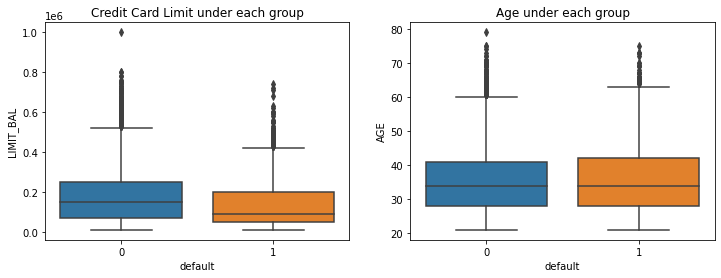

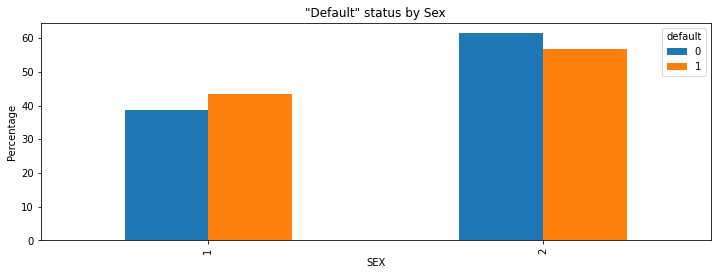

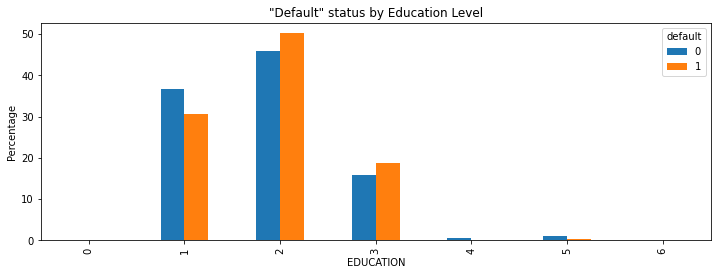

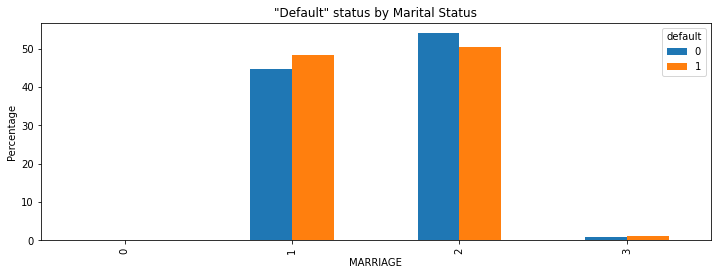

In [15]:
# For other variables in general
print('Non-defaulted customers:\n',
      df_0[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe(), '\n')
print('Defaulted customers:\n', df_1[[
      'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe(), '\n')


def univariate_plot(title, col):
    """Produce barcharts for a single variable, grouped by default status. """
    group_df = df.groupby(['default', col])[col].count().unstack(0)
    group_df.iloc[:, 0] = 100 * group_df.iloc[:, 0] / group_df.iloc[:, 0].sum()  # convert to %
    group_df.iloc[:, 1] = 100 * group_df.iloc[:, 1] / group_df.iloc[:, 1].sum()  # convert to %
    ax = group_df.plot.bar(title=f'"Default" status by {title}', figsize=(12, 4))
    ax.set_ylabel('Percentage')
    plt.show()


# Credit card limit and age boxplot
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.boxplot(x='default', y='LIMIT_BAL', data=df[['LIMIT_BAL', 'default']])
plt.title('Credit Card Limit under each group')
plt.subplot(122)
sns.boxplot(x='default', y='AGE', data=df[['AGE', 'default']])
plt.title('Age under each group')
plt.show()

# sex, education, marriage bar chart, with percentage
univariate_plot(title='Sex', col='SEX')
univariate_plot(title='Education Level', col='EDUCATION')
univariate_plot(title='Marital Status', col='MARRIAGE')

# III. Methods

## III.A 5-fold Cross Validation   
<font color="blue"> 
- Explain and use 5-fold cross validation to find a good neural network parameters including the structure to report the CV accuracies. 

Cross-validation (CV) has been known and widely used to remediate potential overfitting issues and improve the forecasting performance. The V-fold cross validation (VFCV) technique is commonly used, where we divide the data into V subsets and each time we hold out one subset to evaluate forecasting performance, while the remaining (V-1) subsets are used for model parameter estimation. This process will repeat V times and thereafter, the average error across V trials is computed. 

In this assignment, we the use 5-fold CV to select the best NN structure. First we **hold out a portion of the entire data** as the **test data**, while the **remaining** becomes our **training data**. Then we to divide the **training data** into 5 subsets and each time we hold out 1 subset to evaluate forecasting performance, while the remaining 4 subsets are used for NN parameter estimation (training). During each iteration, we train the model using the training set and record fitting performance on validation set at different NN structures.


At last, the structure leading to the lowest error across the 5 trials is used to produce forecast on the **test data**.

The following cell defines a function `MAPE` to return the MAPE % of two series and `CV_regression`, which sequentially goes through different network structures, train the weights of each structure using the `NeuralNet` class and record the 5-fold CV performance for each structure. More explanation of the code can be found in the next section.

In [16]:
def MAPE(T, T_pred):
    T, T_pred = np.array(T).flatten(), np.array(T_pred).flatten()
    return np.mean(np.abs((T - T_pred) / T)) * 100


def CV_regression(train_df, test_df, min_neuron=1, max_neuron=64, stepsize=5, niter=50):
    mape_CV = []  # store CV mape results for each structure at each fold
    mape_test = [] # store test mapes for each structure

    X_tr, T_tr = train_df.loc[:, train_df.columns != 'load'], train_df.load
    X_test, T_test = test_df.loc[:, test_df.columns != 'load'], test_df.load

    for n_neuron in range(min_neuron, max_neuron + 1, stepsize):
        nn_param = [X_tr.shape[1] - 1, n_neuron, 1]
        for yr in np.unique(train_df.year):  # enumerate each year in train
            tr, val = X_tr[X_tr.year != yr].drop('year', axis=1), X_tr[X_tr.year == yr].drop('year', axis=1)

            nn = NeuralNet(nn_param)  # initialize for validation
            nn.train(tr.to_numpy(), T_tr[tr.index].to_numpy().reshape(-1, 1), niter=niter)
            T_pred = nn.use(val)

            mape_CV.append([tuple(nn_param), MAPE(T_tr[val.index], T_pred)])  # nn_param is tuple to group by
        #print(f'Testing for structure {nn_param}...')
        nn = NeuralNet(nn_param)  # initialize for testing
        nn.train(X_tr.drop('year', axis=1).to_numpy(), T_tr.to_numpy().reshape(-1, 1), niter=niter)
        T_pred = nn.use(X_test)
        mape_test.append([tuple(nn_param), MAPE(T_test, T_pred)])

    # convert list to df and merge
    cv_result = pd.DataFrame(np.array(mape_CV), columns=['nn_param', 'tr_mape'])
    cv_result['tr_mape'] = cv_result['tr_mape'].astype(float)  # coerce to float before group by mean
    cv_result = cv_result.groupby(['nn_param'], as_index=False)['tr_mape'].mean()  # calculate avg mape
    test_result = pd.DataFrame(np.array(mape_test), columns=['nn_param', 'test_mape'])
    test_result['test_mape'] = test_result['test_mape'].astype(float)
    result_df = cv_result.merge(test_result, on='nn_param')

    return result_df

## III.B Nonlinear Regression 
<font color="blue"> 
- Summarize the nonlinear regression model. 
- Use the NeuralNet class for regression to apply to your data. 
- Explain your codes (not in comment). 

Nonlinear regression is a regression in which the dependent or criterion variables are modeled as a non-linear function of model parameters and one or more independent variables. The model parameters are still in linear combination with the features. The regression is called "nonlinear" is because the relationships between the dependent and independent parameters are not linear (we are using non-linear activation function in this case).

The following cell applies the `CV_regression` function we defined earlier and the `NeuralNet` class to train models and record the CV and test performance (MAPE %) under each network structure. 

The codes below sequentially goes through different network structures, train the weights of each structure using the `NeuralNet` class and record the 5-fold CV performance for each structure. Here we use MAPE as the error metrics since all the loads in the dataset are above 0. Given 6 years of load history, we **hold out the last year (2014)** as the **test year** and **the first 5 years** as the **training data** to conduct the 5-fold CV. 

As adding one more hidden layer to the network increases the amount of weights to be estimated and dramatically slows down the training process, **we stick with a shallow neural network with 1 hidden layer in this assignment and search the number of neurons in the hidden layer. It turns out to give very promising forecasting performance at certain numbers of neurons in the hidden layer**. It is worth mentioning that if we want to try out more hidden layers, the same grid search mechanism can be conducted to find the best structure using the CV. 

Besides the input training dataframe and test dataframe, the parameters of this function include the minimum and maximum number of neurons we want to try at the hidden layer, a stepsize and the iterations we want to train for the NNs (default=50). Concretely, the number of neuron will start from the min_neuron (default=1) and gradually increases to the maximum (default=64) by a stepsize we define (default=5). 

In this function, we use a local variable `mape_CV` to store the MAPE results for each structure at each fold, and `mape_test` to store the test performance for each NN structure. The function returns a dataframe that stores the training and test error of each NN structure. 

For the data preprocessing, the data will first go through the one-hot encoding for the dummy variables (i.e., month, hour, day-of-week), and then be splitted into training and test sets. Thereafter, the data sets will serve as input to the `CV_regression` function. 

In [17]:
def CV_regression(train_df, test_df, min_neuron=1, max_neuron=64, stepsize=5, niter=50):
    mape_CV = []  # store CV mape results for each structure at each fold
    mape_test = [] # store test mapes for each structure

    X_tr, T_tr = train_df.loc[:, train_df.columns != 'load'], train_df.load
    X_test, T_test = test_df.loc[:, test_df.columns != 'load'], test_df.load

    for n_neuron in range(min_neuron, max_neuron + 1, stepsize):
        nn_param = [X_tr.shape[1] - 1, n_neuron, 1]
        for yr in np.unique(train_df.year):  # enumerate each year in train
            tr, val = X_tr[X_tr.year != yr].drop('year', axis=1), X_tr[X_tr.year == yr].drop('year', axis=1)

            nn = NeuralNet(nn_param)  # initialize for validation
            nn.train(tr.to_numpy(), T_tr[tr.index].to_numpy().reshape(-1, 1), niter=niter)
            T_pred = nn.use(val)

            mape_CV.append([tuple(nn_param), MAPE(T_tr[val.index], T_pred)])  # nn_param is tuple to group by
        #print(f'Testing for structure {nn_param}...')
        nn = NeuralNet(nn_param)  # initialize for testing
        nn.train(X_tr.drop('year', axis=1).to_numpy(), T_tr.to_numpy().reshape(-1, 1), niter=niter)
        T_pred = nn.use(X_test)
        mape_test.append([tuple(nn_param), MAPE(T_test, T_pred)])

    # convert list to df and merge
    cv_result = pd.DataFrame(np.array(mape_CV), columns=['nn_param', 'tr_mape'])
    cv_result['tr_mape'] = cv_result['tr_mape'].astype(float)  # coerce to float before group by mean
    cv_result = cv_result.groupby(['nn_param'], as_index=False)['tr_mape'].mean()  # calculate avg mape
    test_result = pd.DataFrame(np.array(mape_test), columns=['nn_param', 'test_mape'])
    test_result['test_mape'] = test_result['test_mape'].astype(float)
    result_df = cv_result.merge(test_result, on='nn_param')

    return result_df


dummy_cols = ['hour', 'month', 'weekday']  # cols for one-hot encoding
load = pd.get_dummies(data=load, columns=dummy_cols, drop_first=False)
train, test = load[load.year != 2014].drop(['date'], axis=1), load[load.year == 2014].drop(['date', 'year'], axis=1)
reg_result = CV_regression(train, test, min_neuron=1, max_neuron=64, stepsize=5, niter=50)

## III.C Nonlinear Logistic Regression
- Summarize the nonlinear logistic regression model. 
- Finish the following NeuralNetLogReg class.
- Check if your codes works well with toy synthetic data. 
- Apply to your classification data. 
- Explain your codes (not in comment). 

Nonlinear logistic regression is a regression used to fit and predict target labels and solve classification problems. It is called logistic regression since it mimics the idea of logistic regression, outputs the probabilities of an observation belonging to a specific class and the probability can in turn be converted into crisp predicted labels. The regression is called "nonlinear" since the relationships between the dependent and independent parameters are not linear (we are using non-linear activation function in this case). 

In the following cell, we define a subclass "NeuralNetClass" from the super class "NeuralNet". We modify the `train` method to convert the vector label T to indicator matrix before feeding into the training process. We also update the `use` method such that both the probability of a class and the crisp output (converted using argmax) can be returned. 

In [18]:
class NeuralNetLogReg(NeuralNet):
    """ Nonlinear Logistic Regression

        Parameters
        ----------
        nunits: list
            the number of inputs, hidden units, and outputs

        Methods
        -------
        forward
            forward processing of neural network

        train
            train the neural network

        use
            apply the trained network for prediction

        Attributes
        ----------
        T_class
            array stores the labels of predicted class
    """
    # if you think, you need additional items to initialize here,
    # add your code for it here
    def __init__(self, nunits):
        super().__init__(nunits)
        self.T_class = None
        
    # Looking at the final summary or comparison table in lecture note,
    # add your codes for forward pass for logistic regression
    def forward(self, X):
        return super().forward(X)

    # This is the error function that we want to minimize
    # what was it? take a look at the lecture note to fill in
    def _objectf(self, T, Y, wpenalty):
        return super()._objectf(T, Y, wpenalty)

    # you must reuse the NeuralNet train since you already modified
    # the objective or error function (maybe both), 
    # you do not have many to change here.
    # MAKE SURE convert a vector label T to indicator matrix and 
    # feed that for training
    def train(self, X, T, **params):
        T = np.asanyarray(T) # convert to np row vector
        self.T_class = np.unique(T)
        T1 = (T.reshape(-1, 1)== self.T_class).astype(int)  # indicator matrix，此处输入的行向量转为2D matrix，input T应是行向量
        return super().train(X, T1, **params)

    # going through forward pass, you will have the probabilities for each label
    # now, you can use argmax to find class labels
    # return both label and probabilities 
    def use(self, X, retZ=False):
        probability = super().use(X, retZ)  # retZ use default 'False'
        label = np.argmax(probability, axis=1)
        return probability, label

We follow the previous assignment and create a function `single_measure` to calculate the F1 score and the MCC score (optional), and `confusion_matrix` to show the confusion matrix of a classification model. We also import the `roc_pr` to calculate the TPR and FPR, and plot the ROC curve using the `roc_curve` function. 

In [19]:
def single_measure(Y, T, out_mcc=False, T_neg=0):
    """
    F1 score:[0, 1], 1=best
    mcc: [-1, 1], 1=best, 0=noskill, -1=worst
    """
    n_TP = np.logical_and(Y == 1, T == 1).sum()
    n_FP = np.logical_and(Y == 1, T == T_neg).sum()
    n_TN = np.logical_and(Y == T_neg, T == T_neg).sum()
    n_FN = np.logical_and(Y == T_neg, T == 1).sum()
    f1 = n_TP / (n_TP + (n_FN + n_FP) / 2)
    if out_mcc == True:
        mcc = (n_TP * n_TN - n_FP * n_FN) / (np.sqrt((n_TP + n_FP) * (n_TP + n_FN) * (n_TN + n_FP) * (n_TN + n_FN)))
        return f1, mcc
    else:
        return f1
    
    
def confusion_matrix(Y, T):
    """ Y    nd.array
             predicted labels
        T    nd.array
             target labels

        @cfm DataFrame
             confusion matrix
    """

    if len(Y) != len(T):
        raise ValueError("Wrong prediction and target length!")

    classes = np.unique(T)
    n_classes = len(classes)

    cfm = pd.DataFrame(np.zeros((n_classes, n_classes)), index=classes, columns=classes, dtype=int)

    Tidx = [T == c for c in classes]
    for c in classes:
        pred_idx = Y == c
        cfm.loc[c, :] = [np.sum(np.logical_and(pred_idx, tidx)) for tidx in Tidx]

    return cfm

def roc_pr(Y, T, T_neg=0):
    """return fpr, tpr, pre, rec and get ready for ROC curve plot."""
    fprs = []
    tprs = []
    pres = []
    recs = []
    # sorted_i = np.argsort(Y)

    for thres in sorted(Y)[::-1]:  # reverse order of the sorted Y
        n_TP = np.logical_and(Y >= thres, T == 1).sum()
        n_FP = np.logical_and(Y >= thres, T == T_neg).sum()
        n_TN = np.logical_and(Y < thres, T == T_neg).sum()
        n_FN = np.logical_and(Y < thres, T == 1).sum()
        # print(n_TP, n_FP, n_TN, n_FN)
        fpr = n_FP / (n_FP + n_TN)
        tpr = n_TP / (n_TP + n_FN)
        fprs.append(fpr)
        tprs.append(tpr)
        precision = n_TP / (n_TP + n_FP)
        recall = n_TP / (n_TP + n_FN)
        pres.append(precision)
        recs.append(recall)

    return fprs, tprs, recs, pres

# plot ROC curve
def roc_curve(fprs, tprs):
    global label
    plt.plot(fprs, tprs, label=f'{label}')
    plt.title('ROC curve')
    plt.xlabel("P(FP)")
    plt.ylabel("P(TP)")
    plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='--')  # add dashed line for dumb classifier
    plt.legend(loc='lower right', prop={'size': 10})

**Then we generate some toy data in the following cell and look at the training performance**. The toy data has two features, 10 observations, 2 class labels and we use a network with 2 neurons in the hidden layer to produce the output, which is in the form of probability and crisp labels. 

In [20]:
# Toy data
X = np.random.rand(10, 2)
T = np.random.randint(2, size=10)

In [21]:
X

array([[0.02403846, 0.81115523],
       [0.23347988, 0.07903879],
       [0.20751954, 0.58995759],
       [0.99750008, 0.73493575],
       [0.86127712, 0.01197995],
       [0.27602604, 0.8429367 ],
       [0.27214014, 0.59350449],
       [0.38957649, 0.71802006],
       [0.8915488 , 0.11816168],
       [0.33953094, 0.77874246]])

In [22]:
T

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [23]:
# training
nunits=[2, 2, 2]
nn=NeuralNetLogReg(nunits)
nn.train(X, T, niter=25)
Y_prob, Y_label = nn.use(X)
print(f'The probability output of each class is:\n{Y_prob}')

The probability output of each class is:
[[ 0.00775263  0.99142092]
 [-0.004779    0.99685506]
 [ 0.00303007  0.99599269]
 [-0.0023794   0.99176416]
 [ 0.49695723  0.49006134]
 [ 0.00666474  0.99247691]
 [-0.00199592  1.00086263]
 [-0.0051374   1.00392666]
 [ 0.49462218  0.49240772]
 [ 0.00350788  0.99554024]]


The training set confusion matrix is:

In [24]:
confusion_matrix(Y_label, T)

,0,1
0,1,1
1,0,8


In [25]:
f1, mcc = single_measure(Y_label, T, out_mcc=True)
print(f'\nF1 score={f1:.4f}, MCC score={mcc:.4f}')


F1 score=0.9412, MCC score=0.6667


From the above confusion matrix and the F1 and MCC score, **we can see that the network has perfectly fits the training data**. 

The following cell creates the `CV_classification` function and uses the `NeuralNetLogReg` class to train models and record the CV and test performance (**F1 and MCC score**) under each network structure. 

The codes below sequentially goes through different network structures, train the weights of each structure using the `NeuralNet` class and record the 5-fold CV performance for each structure. We **randomly hold out 20% of the data** as the **test data** and **for the rest 80% data, we conduct the 5-fold CV to select the best NN structure**. Same to the regression problem, we stick with a shallow neural network with 1 hidden layer and search the number of neurons in the hidden layer which results in the best performance across the validation sets. It is worth mentioning that if we want to try out more hidden layers, the same grid search mechanism can be conducted to find the best structure using CV. 

Besides the input training dataframe and test dataframe, the parameters of this function include the minimum and maximum number of neurons we want to try at the hidden layer, a stepsize and the iterations we want to train for the NNs (default=50). Concretely, the number of neuron will start from the min_neuron (default=1) and gradually increases to the maximum (default=64) by a stepsize we define (default=5). We can also change the value of `cv` to be another number as desired to conduct other folds of CV. Here we stick with `cv`=5. We also fix the random state of the train/test spliting such that our results can be reproducible. **Different from the regression problem, now we have 2 output neurons since we are solving a classification problem with 2 possible class labels.**

In this function, we use a local variable `clf_CV` to store the classification performance (f1 and MCC score) for each structure at each fold, and `clf_test` to store the test performance for each NN structure. The function returns a dataframe that stores the training and test performance of each NN structure. 

The `CV_classification` function also includes some necessary pre-processing steps such as creating dummy variables for the categorical features, drop the categorical columns that have too few positive class labels in data, and the data partitioning. Further, it will organize the results that are good for presenting and visualization. At last, the chosen NN structure will be used to predict on test data using the entire training data for weight training. The function will return the confusion matrix and the probability forecast on the test set. 

In [26]:
def CV_classification(data, min_neuron=1, max_neuron=64, stepsize=5, niter=50,
                      drop_thres=50, drop_first=False, test_pct=.2, cv: int = 5, seed=1):
    """
    Dummy coding, Drop dummy variables with too few positive class labels, and then Split data.
    data: input data
    drop_thres: Drop dummy variables with too few positive class labels in data
    drop_first: whether to get k-1 dummies to avoid colinearity issue. For NN this is False in default.
    cv: can be False or an assigned int.
    """
    # dummy codings
    global dummy_cols, T_col
    data = pd.get_dummies(data=data, columns=dummy_cols, drop_first=drop_first)
    data = data.loc[:, data.sum() > drop_thres]

    # train/test = 80/20 split
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)  # shuffle the rows before cv
    train, test = data.iloc[:-int(test_pct * len(data)), :], data.iloc[-int(test_pct * len(data)):, :]
    X_train, T_train = train.drop(T_col, axis=1), train[T_col]
    X_test, T_test = test.drop(T_col, axis=1), test[T_col]

    # CV in train data
    clf_CV = []
    clf_test = []

    for n_neuron in range(min_neuron, max_neuron + 1, stepsize):
        nn_param = [train.shape[1] - 1, n_neuron, 2]  # -1 since need to remove T_col. 2 output neurons.
        for i in range(cv):
            val = train.iloc[i * int(len(train) / cv):(i + 1) * int(len(train) / cv) + 1, :]
            X_val, T_val = val.drop(T_col, axis=1), val[T_col]
            tr = train.loc[~train.index.isin(val.index)]  # any obs other than val
            X_tr, T_tr = tr.drop(T_col, axis=1), tr[T_col]
            nn = NeuralNetLogReg(nn_param)  # initialize for validation
            nn.train(X_tr.to_numpy(), T_tr, niter=niter)
            _, T_label = nn.use(X_val)  # take label only
            f1, mcc = single_measure(T_label, T_val, out_mcc=True)
            clf_CV.append([tuple(nn_param), f1, mcc])  # nn_param is tuple

        #print(f'Testing for structure {nn_param}...')
        nn = NeuralNetLogReg(nn_param)  # initialize for testing
        nn.train(X_train.to_numpy(), T_train, niter=niter)
        _, T_label = nn.use(X_test)  # take label only
        f1, mcc = single_measure(T_label, T_test, out_mcc=True)
        clf_test.append([tuple(nn_param), f1, mcc])

    # Process results. convert list to df and merge
    cv_result = pd.DataFrame(np.array(clf_CV), columns=['nn_param', 'cv_f1', 'cv_mcc'])
    cv_result.cv_f1, cv_result.cv_mcc = cv_result.cv_f1.astype(float), cv_result.cv_mcc.astype(float)  # coerce
    cv_result = cv_result.groupby(['nn_param'], as_index=False).mean()  # calculate avg mape
    test_result = pd.DataFrame(np.array(clf_test), columns=['nn_param', 'test_f1', 'test_mcc'])
    test_result.test_f1, test_result.test_mcc = test_result.test_f1.astype(float), test_result.test_mcc.astype(float)
    result_df = cv_result.merge(test_result, on='nn_param')
    
    # train with select structure
    sort_result = result_df.sort_values(by=['cv_f1', 'cv_mcc'], ascending=False)
    nn_param = sort_result.at[0, 'nn_param']
    nn = NeuralNetLogReg(nn_param)  # initialize for validation
    nn.train(X_train.to_numpy(), T_train, niter=niter)
    T_prob, T_label = nn.use(X_test)  # take both probability and labels only
    
    cm = confusion_matrix(T_label, T_test)
    
    return result_df, cm, T_prob, T_test

dummy_cols = ['PAY_%d' % i for i in range(1, 4 + 1)] + ['SEX', 'EDUCATION', 'MARRIAGE']  # cols for dummy
T_col = 'default'
var_list = ['PAY_%d' % i for i in range(1, 4 + 1)] + ['PAY_AMT%d' % i for i in range(1, 6 + 1)] + \
           ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']
full = df[var_list + ['default']]
class_perf, conf_matrix, T_prob, T_test = CV_classification(full, min_neuron=1, max_neuron=64, stepsize=5, niter=50)

# get fprs, tprs for ROC curve plot
fprs, tprs, _, _ = roc_pr(T_prob[:,1], T_test, T_neg=0)

# IV - Results

- Presents the results of comparison of the tested models with CV errors.
- Visualize the results 
- What do you think about the results? 

## IV.A Nonlinear Regression 

The following cell gives the result of the nonlinear regression model using 5-fold cross validation. A total of 13 neural networks structures were tried out. Here I fix the input neuron to be 45 (45 features), using one hidden layer and varying the units in the hidden layer from 1 to 61, with a stepsize of 5. I only choose to run 50 iterations for each training process since the convergence rate of the NN algorithm is fast. 

We can tell from the performance table and the plot below, that the **CV training error** is minimized at the structure **(45, 26, 1)** with **3.311%**. Although the **test error** is minimized at **(45, 26, 1)**, with a test error of **3.004%**, our selection from CV is still a robust selection. This proves the viability of the CV method and it is able to select the best NN structure from the training set and on the test set, it generalizes well. The chosen number of neurons is at the middle of the search space and it is close to the number of input features.

In [27]:
reg_result.rename(columns={'tr_mape': 'cv_mape'}, inplace=True)
reg_result

,nn_param,cv_mape,test_mape
0,"(45, 1, 1)",5.473894,5.477036
1,"(45, 6, 1)",3.945615,4.197406
2,"(45, 11, 1)",3.719616,3.541101
3,"(45, 16, 1)",3.395541,3.004150
4,"(45, 21, 1)",3.420524,3.280093
5,"(45, 26, 1)",3.311869,3.333673
6,"(45, 31, 1)",3.419770,3.354109
7,"(45, 36, 1)",3.477383,3.213593
8,"(45, 41, 1)",3.372717,3.327462
9,"(45, 46, 1)",3.497112,3.347829


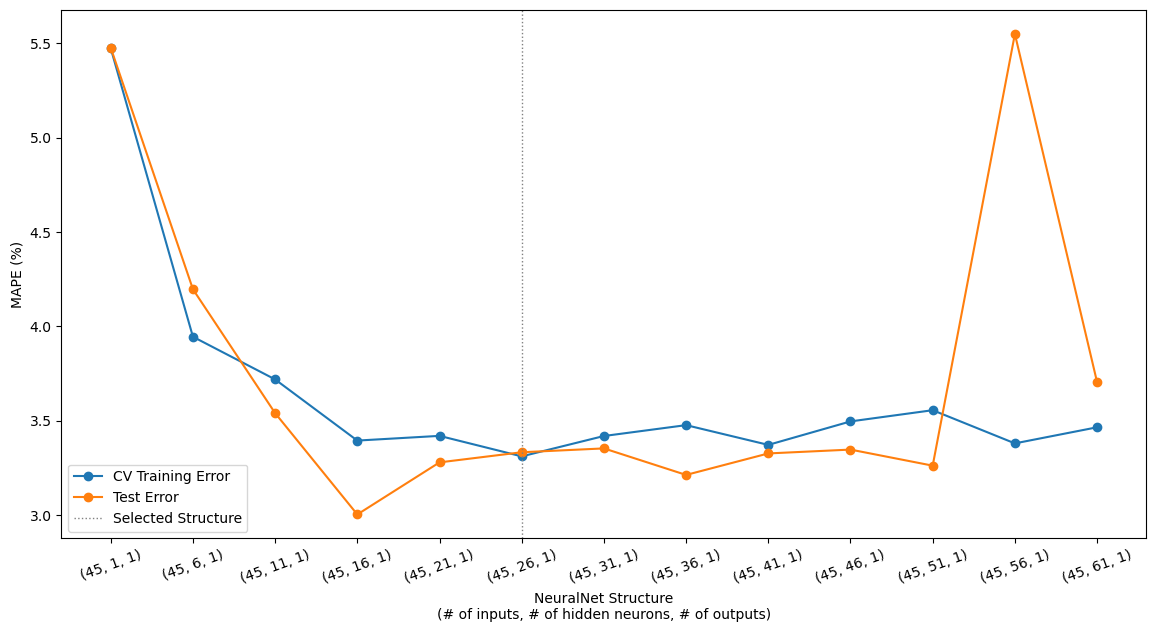

In [30]:
plt.figure(figsize=(14,7),dpi=100)
ax = plt.gca()
reg_result.plot(x='nn_param', y='cv_mape', marker='o', ax=ax, label='CV Training Error')
reg_result.plot(x='nn_param', y='test_mape', marker='o', ax=ax, label='Test Error')
plt.xlabel('NeuralNet Structure\n(# of inputs, # of hidden neurons, # of outputs)')
plt.ylabel('MAPE (%)')
plt.axvline(x=5, color='gray', linestyle=':', linewidth=1, label='Selected Structure')
plt.xticks(np.arange(13), reg_result.nn_param, rotation=20)  # 13 structures
plt.legend()
plt.show()

## IV.B Nonlinear Logistic Regression

The following cell gives the result of the nonlinear logistic regression model using 5-fold cross validation. A total of 13 neural networks structures were tried out. Here I fix the input neuron to be 45 (45 features), using one hidden layer and varying the units in the hidden layer from 1 to 61, with a stepsize of 5. I only choose to run 50 iterations for each training process since the convergence rate of the NN algorithm is fast. 

We can tell from the performance table and the plot below, that the **CV F1 score** and the **CV MCC score** (blue curves) both are maximized at the structure **(45, 1, 2)**, which coincide with the F1 and MCC score on the test set (orange curves). **This proves the viability of the CV method and it is able to select the best NN structure from the training set and generalize on the test set.** The chosen number of neurons is at the beginning of the search space (1 neuron). We also observe that the performance scores (both F1 and MCC) are higher on the test set than among the validation sets. 

In [31]:
class_perf

,nn_param,cv_f1,cv_mcc,test_f1,test_mcc
0,"(45, 1, 2)",0.479983,0.401056,0.504128,0.429670
1,"(45, 6, 2)",0.457216,0.391996,0.482828,0.419755
2,"(45, 11, 2)",0.455439,0.390907,0.485915,0.421800
3,"(45, 16, 2)",0.457677,0.392632,0.479188,0.417515
4,"(45, 21, 2)",0.456306,0.391980,0.480000,0.417359
5,"(45, 26, 2)",0.450674,0.385791,0.485671,0.421265
6,"(45, 31, 2)",0.458391,0.393052,0.483561,0.421378
7,"(45, 36, 2)",0.458078,0.391774,0.484879,0.421412
8,"(45, 41, 2)",0.455901,0.390610,0.489245,0.423507
9,"(45, 46, 2)",0.456054,0.391513,0.468718,0.409143


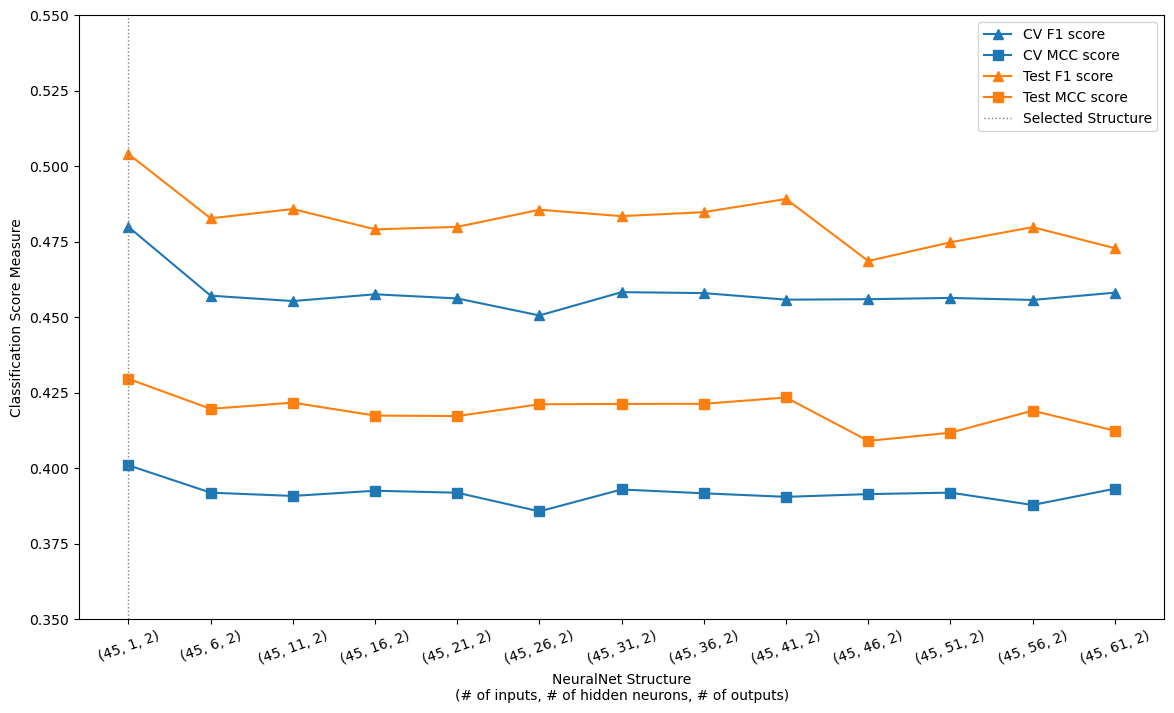

In [32]:
plt.figure(figsize=(14,8),dpi=100)
ax = plt.gca()
class_perf.plot(x='nn_param', y='cv_f1', marker='^', markersize=7, ax=ax, label='CV F1 score', color='C0')
class_perf.plot(x='nn_param', y='cv_mcc', marker='s', markersize=7, ax=ax, label='CV MCC score', color='C0')
class_perf.plot(x='nn_param', y='test_f1', marker='^', markersize=7, ax=ax, label='Test F1 score', color='C1')
class_perf.plot(x='nn_param', y='test_mcc', marker='s', markersize=7, ax=ax, label='Test MCC score', color='C1')
plt.xlabel('NeuralNet Structure\n(# of inputs, # of hidden neurons, # of outputs)')
plt.ylabel('Classification Score Measure')
plt.ylim(.35, .55)
plt.axvline(x=0, color='gray', linestyle=':', linewidth=1, label='Selected Structure')
plt.xticks(np.arange(13), class_perf.nn_param, rotation=20)  # 13 structures
plt.legend(loc='upper right')
plt.show()

The following cell gives the confusion matrix and ROC curve on the test set from the selected NN structure. From the confusion matrix, we can tell that the model is better at capturing the negative classes correctly.

In [33]:
conf_matrix

,0,1
0,4459,770
1,249,522


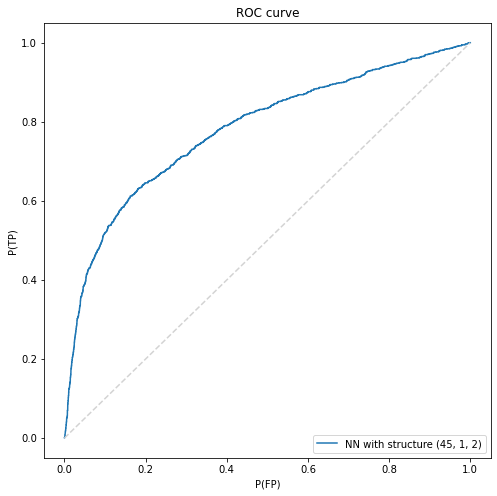

In [34]:
label='NN with structure (45, 1, 2)'
plt.figure(figsize=(8,8))
roc_curve(fprs, tprs)

# Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

The challenge from this assignment comes from the cross validation setup, in which different NN structures will be tried out, including the number of layers and the number of neurons in each layer. We found out that increasing the number of layer will dramatically increase the training time on a personal laptop, so we proceed with tuning the number of neurons in a shallow network, which has a fixed one hidden layer. The results from the classification dataset was a bit surprising as the CV selects only 1 neuron as the final model, this implies that a more complex NN structure may not lead to better prediction performance. 

Also I learn about different activation functions from the extra credit section and how to implement them in the training step. 

# Extra Credit

Now you are testing various **activation functions** in this section. Use the best neural network structure and explore 3 different activation functions of your choice (one should be *tanh* that you used in the previous sections). 
You should use cross validation to discover the best model (with activation function). 


One extra credit is assigned when you finish the work completely. 


In this section, I tried on 3 different activation functions, sigmoid, tanh and linear on the nonlinear regression model, with chosen NN structure: **(45, 36, 1)**. The implementation of the nonlinear logistic regression model is very close and not included in this section. The denotation of the activation functions and their derivatives are listed below. 

**sigmoid function**:

$$
h(x) = sig(x) = \frac{1}{1+e^{-x}}
\\
h'(x) = sig(x)(1-sig(x))
$$

**tanh**:
$$
h(x) = tanh(x) = \frac{sinhx}{coshx} = \frac{e^x-e^{-x}}{e^x+e^{-x}}
\\
h'(x) = 1-tanh^2(x)
$$

**linear**:
$$
h(x) = x
\\
h'(x) = 1
$$

In the following cell, we define a subclass `NeuralNetActFunc` from the super class `NeuralNet`. Using this subclass will override the `forward` and `backward` methods in the super class `NeuralNet` and allow us to define the activation function we want to use to for our NN structure and training process. 

In [35]:
class NeuralNetActFunc(NeuralNet, object):
    """ Choose from 3 different activation functions:
        sigmoid, tanh, and linear

        Parameters
        ----------
        nunits: list
            the number of inputs, hidden units, and outputs

        Methods
        -------
        forward
            forward processing of neural network

        backward
            back-propagation of neural network

        Attributes
        ----------
        activation
            choose from 3 different activation functions:
            sigmoid, tanh, and linear
    """

    # additional items to initialize
    def __init__(self, nunits, activation='tanh'):
        super().__init__(nunits)
        self.activation = activation

    def forward(self, X):
        t = X
        Z = []  # intermediate hidden instances

        for i in range(self._nLayers):
            Z.append(t)
            if i == self._nLayers - 1:
                t = np.dot(self.add_ones(t), self._W[i])
            else:
                if self.activation == 'tanh':
                    t = np.tanh(np.dot(self.add_ones(t), self._W[i]))
                elif self.activation == 'sigmoid':
                    t = expit(np.dot(self.add_ones(t), self._W[i]))
                elif self.activation == 'linear':
                    t = np.dot(self.add_ones(t), self._W[i])
                else:
                    print(f'activation function do not exist!')
        return (t, Z)

    def backward(self, error, Z, T, lmb=0):
        delta = error
        N = T.size
        dws = []

        for i in range(self._nLayers - 1, -1, -1):
            rh = float(self.rho[i]) / N

            if i == 0:
                lmbterm = 0
            else:
                lmbterm = lmb * \
                          np.vstack(
                              (np.zeros((1, self._W[i].shape[1])), self._W[i][1:, ]))

            dws.insert(
                0, (-rh * np.dot(self.add_ones(Z[i]).T, delta) + lmbterm))

            if i != 0:
                if self.activation == 'tanh':
                    delta = np.dot(delta, self._W[i][1:, :].T) * (1 - Z[i] ** 2)
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, self._W[i][1:, :].T) * Z[i] * (1 - Z[i])
                elif self.activation == 'linear':
                    delta = np.dot(delta, self._W[i][1:, :].T)

        return self.pack(dws)

In the following cell, we define a function `CV_ActFunc` to conduct 5-fold CV on each activation function using the best NN structure: (45, 26, 1). It returns the CV performance (MAPE%) as well as the test set performance. We use a local variable `mape_CV` to score the CV MAPE results for each activation function and `mape_test` to store the test MAPE results. 

In [38]:
def CV_ActFunc(train_df, test_df, actfunc=('linear', 'sigmoid', 'tanh'), n_input=45, n_neuron=36, n_output=1, niter=50):
    mape_CV = []  # store CV mape results for each activation function at each fold
    mape_test = []  # store test mapes for each activation function

    X_tr, T_tr = train_df.loc[:, train_df.columns != 'load'], train_df.load
    X_test, T_test = test_df.loc[:, test_df.columns != 'load'], test_df.load

    for func in actfunc:
        nn_param = [n_input, n_neuron, n_output]
        for yr in np.unique(train_df.year):  # enumerate each year in train
            tr, val = X_tr[X_tr.year != yr].drop('year', axis=1), X_tr[X_tr.year == yr].drop('year', axis=1)

            nn = NeuralNetActFunc(nn_param, activation=func)  # initialize for validation
            nn.train(tr.to_numpy(), T_tr[tr.index].to_numpy().reshape(-1, 1), niter=niter)
            T_pred = nn.use(val)

            mape_CV.append([func, MAPE(T_tr[val.index], T_pred)])
        print(f'Testing for structure: {nn_param}, activation function: {func}...')
        nn = NeuralNetActFunc(nn_param, activation=func)  # initialize for testing
        nn.train(X_tr.drop('year', axis=1).to_numpy(), T_tr.to_numpy().reshape(-1, 1), niter=niter)
        T_pred = nn.use(X_test)
        mape_test.append([func, MAPE(T_test, T_pred)])

    # Process results. convert list to df and merge
    cv_result = pd.DataFrame(np.array(mape_CV), columns=['activation', 'cv_mape'])
    cv_result['cv_mape'] = cv_result['cv_mape'].astype(float)  # coerce to float before group by mean
    cv_result = cv_result.groupby(['activation'], as_index=False).mean()  # calculate avg mape
    test_result = pd.DataFrame(np.array(mape_test), columns=['activation', 'test_mape'])
    test_result['test_mape'] = test_result['test_mape'].astype(float)
    result_df = cv_result.merge(test_result, on='activation')

    return result_df

actfunc_result = CV_ActFunc(train, test, actfunc=('linear', 'sigmoid', 'tanh'), n_input=45, n_neuron=26, n_output=1,
                            niter=50)

Testing for structure: [45, 26, 1], activation function: linear...
Testing for structure: [45, 26, 1], activation function: sigmoid...
Testing for structure: [45, 26, 1], activation function: tanh...


The following cell gives the CV and test set performance of each activation function. 

In [39]:
actfunc_result

,activation,cv_mape,test_mape
0,linear,5.584194,5.607010
1,sigmoid,4.807838,4.048731
2,tanh,3.395417,3.296822


The following cell visualizes the training and test error of each activation function. Under the specified parameter settings, **we observe the tanh function gives the lowest MAPE errors on both the training and the test set**. Therefore, **the best model in our regression case study will be the structure (45, 26, 1) with tanh as the activation function**. 

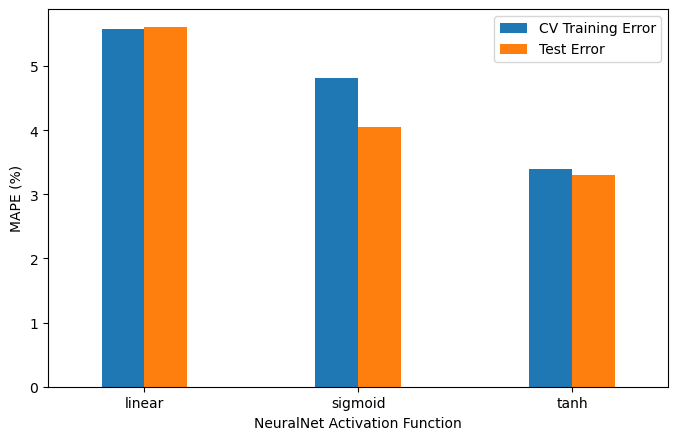

In [40]:
plt.figure(figsize=(8,5),dpi=100)
ax = plt.gca()
actfunc_result.plot.bar(x='activation', ax=ax, color=['C0', 'C1'], width=0.4, rot=0) # rotation=0 deg
plt.xlabel('NeuralNet Activation Function', size=10)
plt.ylabel('MAPE (%)', size=10)
plt.legend((['CV Training Error', 'Test Error']), loc='upper right')
plt.show()

# References

(1). GEFCom2014 data. Retrieved from http://blog.drhongtao.com/2017/03/gefcom2014-load-forecasting-data.html

# How to start?

* Download [a3.tgz](http://webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/a3.tgz). 
* Unzip the python files to current working directory.
* Import the necessary classes or functions including NeuralNet.

## Grading

DO NOT forget to submit your data! Your notebook is supposed to run fine after running your codes. 

** Note: this is a WRITING assignment. Proper writing is REQUIRED. Comments are not considered as writing. ** 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Data | 
 | 2| Includes description of your data
 | 3| Plots to visualize data 
 | 5| Reading and analyzing the plots 
40 | Methods | 
 | 10| Summary of CV & correctness of implementation
 | 5| Summary of nonlinear regression 
 | 5| Explanation of codes
 | 5| Summary of nonlinear logistic regression 
 | 5| Explanation of codes
 |10| Examination of correct implementation (NonlinearLogReg) with toy data.
40 | Results | Your Data
| 10| Presentaion of CV results
| 10| Discussions about parameter/network structure choice 
| 10| plots for results
| 10| Discussion about the prediction results. Try to analyze what nonlinear regression model learned. 
5 | Conclusions 
